In [678]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sankeyflow import Sankey
import squarify

from math import pi
from scipy.interpolate import PchipInterpolator

from bokeh.plotting import figure, show
from bokeh.io import curdoc, output_notebook
from bokeh.models import BoxZoomTool, ResetTool, PanTool, WheelZoomTool, HoverTool, AnnularWedge, ColumnDataSource, Legend, LegendItem, Plot, Range1d
from bokeh.palettes import PuBu, Inferno256, Category20

In [643]:
df_main = pd.read_csv("./referenced_data.csv")
df_main.dropna(inplace=True)
df_main

,UBN,Reference No (URN),Date_Purchase,Date_Cash,Buyer,Party,Status,Denominations
0,TL11448,00001201904120000001166,2019/04/12,2019/04/25,A B C INDIA LIMITED,BHARATIYA JANATA PARTY,Paid,0.10
1,TL11447,00001201904120000001166,2019/04/12,2019/04/25,A B C INDIA LIMITED,BHARATIYA JANATA PARTY,Paid,0.10
2,TL11441,00001201904120000001166,2019/04/12,2019/04/25,A B C INDIA LIMITED,BHARATIYA JANATA PARTY,Paid,0.10
3,OL1113,00001201904120000001166,2019/04/12,2019/04/25,A B C INDIA LIMITED,BHARATIYA JANATA PARTY,Paid,0.01
4,OL1118,00001201904120000001166,2019/04/12,2019/04/25,A B C INDIA LIMITED,BHARATIYA JANATA PARTY,Paid,0.01
...,...,...,...,...,...,...,...,...
18736,OC15695,00001202401110000003729,2024/01/11,2024/01/23,WESTWELL GASES PRIVATE LIMITED,DRAVIDA MUNNETRA KAZHAGAM (DMK),Paid,1.00
18737,OC15693,00001202401110000003729,2024/01/11,2024/01/23,WESTWELL GASES PRIVATE LIMITED,DRAVIDA MUNNETRA KAZHAGAM (DMK),Paid,1.00
18738,OC15697,00001202401110000003729,2024/01/11,2024/01/23,WESTWELL GASES PRIVATE LIMITED,DRAVIDA MUNNETRA KAZHAGAM (DMK),Paid,1.00
18739,OC17803,00001202401110000003729,2024/01/11,2024/01/23,WESTWELL GASES PRIVATE LIMITED,DRAVIDA MUNNETRA KAZHAGAM (DMK),Paid,1.00


In [644]:
def create_aggregate(df, grouper):
    df = df.groupby(grouper).agg({"Denominations": lambda x: x.sum()}).reset_index()
    df.sort_values(by="Denominations", ascending=False, inplace=True)
    return df

In [645]:
def plot_scatter(x, y, title='Scatter Plot of X and Y Coordinates', x_label='X', y_label='Y', color="cyan", color_map=None, size_map=None):
    output_notebook()
    curdoc().theme = 'dark_minimal'

    p = figure(width=800, height=600, title=title)

    use_color = color_map if color_map is not None else color
    use_size = size_map if size_map is not None else 8
    p.scatter(x, y, size=use_size, color=use_color, alpha=0.5, legend_label='Data')

    p.xaxis.axis_label = x_label
    p.yaxis.axis_label = y_label
    p.grid.visible = True

    coefficients = np.polyfit(x, y, 1)
    slope = coefficients[0]
    intercept = coefficients[1]
    trendline = slope * x + intercept
    p.line(x, trendline, line_color='blue', line_width=1, legend_label='Trendline')

    hover = HoverTool(tooltips=[('X', '@x'), ('Y', '@y')])
    p.add_tools(hover)
    p.add_tools(PanTool(), BoxZoomTool(), WheelZoomTool(), ResetTool())
    show(p)

In [646]:
def plot_lines(df, x, y, cat, title='Line Chart', x_label='X', y_label='Y', color_map=None):
    output_notebook()
    curdoc().theme = 'dark_minimal'

    p = figure(width=1200, height=600, title=title)

    aggregated_df = df.groupby(cat)[y].sum().reset_index(drop=True)
    top_20_categories = aggregated_df.nlargest(20, y)[cat]
    df = df[df[cat].isin(top_20_categories)]

    categories = df[cat].unique()
    colors = color_map if color_map else Category20[len(categories)]

    for i, category in enumerate(categories):
        category_data = df[df[cat] == category]
        p.line(category_data[x], category_data[y], line_color=colors[i % len(colors)], line_width=2, legend_label=category)

    p.legend.spacing = 0
    p.legend.margin = 0
    p.legend.padding = 0
    p.legend.label_text_font_size = '6pt'
    p.legend.click_policy = 'hide'
    p.add_layout(p.legend[0], 'right')

    p.add_tools(PanTool(), BoxZoomTool(), WheelZoomTool(), ResetTool())
    show(p)

In [647]:
def plot_donut_chart(column, title='Donut Chart', color_map=None):
    output_notebook()

    xdr = Range1d(start=-2, end=2)
    ydr = Range1d(start=-2, end=2)

    p = Plot(x_range=xdr, y_range=ydr)
    p.title.text = title
    p.toolbar_location = None

    aggregated = column.value_counts()
    percentages = aggregated.apply(lambda x: x/aggregated.sum())
    angles = percentages.map(lambda x: 2*pi*x).cumsum().tolist()

    source = ColumnDataSource(dict(
        start  = [0] + angles[:-1],
        end    = angles,
        colors = color_map
    ))

    glyph = AnnularWedge(x=0, y=0, inner_radius=1.2, outer_radius=1.8,
                         start_angle="start", end_angle="end",
                         line_color="grey", line_width=3, fill_color="colors")
    r = p.add_glyph(source, glyph)

    legend = Legend(location="center")
    for i, name in enumerate([key for key, value in aggregated.items()]):
        legend.items.append(LegendItem(label=name, renderers=[r], index=i))
    p.add_layout(legend, "center")

    show(p)

In [648]:
transactions = df_main.groupby(["Party", "Buyer", "Date_Purchase", "Date_Cash"]).agg({"Denominations": lambda x: x.sum()}).sort_values(by=["Date_Purchase", "Denominations"], ascending=[True, False]).reset_index()
transactions

,Party,Buyer,Date_Purchase,Date_Cash,Denominations
0,BHARATIYA JANATA PARTY,ESSEL MINING AND INDS LTD,2019/04/12,2019/04/20,50.00
1,BHARATIYA JANATA PARTY,MEGHA ENGINEERING AND INFRASTRUCTURES LI MITED,2019/04/12,2019/04/16,45.00
2,BHARATIYA JANATA PARTY,PHL FINIVEST PVT LTD,2019/04/12,2019/04/18,40.00
3,BHARATIYA JANATA PARTY,GRASIM INDUSTRIES LTD,2019/04/12,2019/04/20,20.00
4,BHARATIYA JANATA PARTY,PIRAMAL CAPITAL AND HOUSING FINANCE LTD,2019/04/12,2019/04/18,10.00
...,...,...,...,...,...
2312,"PRESIDENT, ALL INDIA CONGRESS COMMITTEE",ABHINANDANSTOCKBROKINGPVTLTD,2024/01/11,2024/01/15,1.00
2313,"PRESIDENT, ALL INDIA CONGRESS COMMITTEE",DYNERE ENGINEERING PRIVATE LIMITED,2024/01/11,2024/01/22,1.00
2314,"PRESIDENT, ALL INDIA CONGRESS COMMITTEE",SIDHARTH AGARWAL,2024/01/11,2024/01/15,0.50
2315,"PRESIDENT, ALL INDIA CONGRESS COMMITTEE",VIDUR GUPTA,2024/01/11,2024/01/15,0.50


In [649]:
parties_agg = create_aggregate(df_main, ["Party"]).reset_index(drop=True)
parties_agg

,Party,Denominations
0,BHARATIYA JANATA PARTY,5594.2011
1,ALL INDIA TRINAMOOL CONGRESS,1592.5214
2,"PRESIDENT, ALL INDIA CONGRESS COMMITTEE",1351.0945
3,BHARAT RASHTRA SAMITHI,1191.1599
4,BIJU JANATA DAL,775.5000
5,DRAVIDA MUNNETRA KAZHAGAM (DMK),632.0000
6,YSR CONGRESS PARTY (YUVAJANA SRAMIKA RYTHU C...,328.7500
7,TELUGU DESAM PARTY,211.5800
8,SHIVSENA,152.4514
9,RASHTRIYA JANTA DAL,72.5000


In [650]:
buyers_agg = create_aggregate(df_main, ["Buyer"]).reset_index(drop=True)
buyers_agg

,Buyer,Denominations
0,FUTURE GAMING AND HOTEL SERVICES PR,1205.0000
1,MEGHA ENGINEERING AND INFRASTRUCTURES LI MITED,821.0000
2,QWIKSUPPLYCHAINPRIVATELIMITED,410.0000
3,HALDIA ENERGY LIMITED,377.0000
4,VEDANTA LIMITED,375.6500
...,...,...
1292,SANDEEP KHANNA AND ASSOCIATES,0.0040
1293,GOURAV KUMAR,0.0030
1294,VIKAS KUMAR GARG,0.0030
1295,WARORA CHANDRAPUR BALLARPUR TOLLRO,0.0010


In [651]:
party_buyers_agg = create_aggregate(df_main, ["Party", "Buyer"]).reset_index(drop=True)
party_buyers_agg

,Party,Buyer,Denominations
0,BHARATIYA JANATA PARTY,MEGHA ENGINEERING AND INFRASTRUCTURES LI MITED,519.0000
1,DRAVIDA MUNNETRA KAZHAGAM (DMK),FUTURE GAMING AND HOTEL SERVICES PR,453.0000
2,ALL INDIA TRINAMOOL CONGRESS,FUTURE GAMING AND HOTEL SERVICES PR,435.0000
3,BHARATIYA JANATA PARTY,QWIKSUPPLYCHAINPRIVATELIMITED,375.0000
4,ALL INDIA TRINAMOOL CONGRESS,HALDIA ENERGY LIMITED,281.0000
...,...,...,...
1653,SHIROMANI AKALI DAL,SANDEEP KHANNA AND ASSOCIATES,0.0040
1654,SHIROMANI AKALI DAL,VIKAS KUMAR GARG,0.0030
1655,SHIROMANI AKALI DAL,GOURAV KUMAR,0.0030
1656,BHARATIYA JANATA PARTY,WARORA CHANDRAPUR BALLARPUR TOLLRO,0.0010


In [652]:
parties_agg["Buyer Count"] = parties_agg["Party"].map(party_buyers_agg.groupby("Party").size())
parties_agg["Buyer Average"] = parties_agg["Party"].map(party_buyers_agg.groupby("Party")["Denominations"].mean())
buyers_agg["Party Count"] = buyers_agg["Buyer"].map(party_buyers_agg.groupby("Buyer").size())
buyers_agg["Party Average"] = buyers_agg["Buyer"].map(party_buyers_agg.groupby("Buyer")["Denominations"].mean())
parties_agg

,Party,Denominations,Buyer Count,Buyer Average
0,BHARATIYA JANATA PARTY,5594.2011,523,10.696369
1,ALL INDIA TRINAMOOL CONGRESS,1592.5214,227,7.015513
2,"PRESIDENT, ALL INDIA CONGRESS COMMITTEE",1351.0945,351,3.849272
3,BHARAT RASHTRA SAMITHI,1191.1599,233,5.112274
4,BIJU JANATA DAL,775.5000,47,16.500000
5,DRAVIDA MUNNETRA KAZHAGAM (DMK),632.0000,15,42.133333
6,YSR CONGRESS PARTY (YUVAJANA SRAMIKA RYTHU C...,328.7500,52,6.322115
7,TELUGU DESAM PARTY,211.5800,37,5.718378
8,SHIVSENA,152.4514,35,4.355754
9,RASHTRIYA JANTA DAL,72.5000,24,3.020833


In [653]:
# Beneficiaries of the biggest 100 transactions
transactions.sort_values(by=["Denominations"], ascending=[False]).reset_index(drop=True).iloc[:100]["Party"].value_counts()

BHARATIYA JANATA PARTY                                          48
ALL INDIA TRINAMOOL CONGRESS                                    14
DRAVIDA MUNNETRA KAZHAGAM (DMK)                                  9
BIJU JANATA DAL                                                  9
PRESIDENT, ALL INDIA CONGRESS COMMITTEE                          7
BHARAT RASHTRA SAMITHI                                           6
YSR  CONGRESS PARTY  (YUVAJANA SRAMIKA RYTHU CONGRESS PARTY)     3
SHIVSENA                                                         3
TELUGU DESAM PARTY                                               1
Name: Party, dtype: int64

In [654]:
# Donors of the biggest 100 transactions
transactions.sort_values(by=["Denominations"], ascending=[False]).reset_index(drop=True).iloc[:100]["Buyer"].value_counts()

FUTURE GAMING AND HOTEL SERVICES PR                 19
MEGHA ENGINEERING AND INFRASTRUCTURES LI MITED      12
VEDANTA LIMITED                                      6
QWIKSUPPLYCHAINPRIVATELIMITED                        4
HALDIA ENERGY LIMITED                                4
UTKAL ALUMINA INTERNATIONAL LIMITED                  4
ESSEL MINING AND INDS LTD                            4
WESTERN UP POWER TRANSMISSION COMPANY LI MITED       3
KEVENTER FOODPARK INFRA LIMITED                      3
CHENNAI GREEN WOODS PRIVATE LIMITED                  2
B G SHIRKE CONSTRUCTION TECHNOLOGY PVT L TD          2
DLF COMMERCIAL DEVELOPERS LIMITED                    2
PRARAMBH SECURITIES PVT LTDPROPRIET                  2
JINDAL STEEL AND POWER LIMITED                       2
RUNGTA SONS P LTD                                    2
BIRLACARBONINDIAPRIVATELIMITED                       2
BHARTI AIRTEL LIMITED                                2
MADANLAL LTD.                                        2
RITHWIK PR

In [655]:
# Who are the BJP's biggest bond donors?
party_buyers_agg[party_buyers_agg["Party"] == "BHARATIYA JANATA PARTY"].reset_index(drop=True)[["Buyer", "Denominations"]].groupby("Buyer").sum().sort_values(by=["Denominations"], ascending=False)

,Denominations
Buyer,
MEGHA ENGINEERING AND INFRASTRUCTURES LI MITED,519.0000
QWIKSUPPLYCHAINPRIVATELIMITED,375.0000
VEDANTA LIMITED,226.6500
BHARTI AIRTEL LIMITED,183.0000
MADANLAL LTD.,175.5000
...,...
RAJIV KUMAR JHA,0.0100
SHIRISH BAJAJ,0.0100
BHAWNA KASAT,0.0050


In [656]:
party_buyers_agg[party_buyers_agg["Buyer"].str.contains("MEGHA")]

,Party,Buyer,Denominations
0,BHARATIYA JANATA PARTY,MEGHA ENGINEERING AND INFRASTRUCTURES LI MITED,519.0
10,BHARAT RASHTRA SAMITHI,MEGHA ENGINEERING AND INFRASTRUCTURES LI MITED,150.0
30,DRAVIDA MUNNETRA KAZHAGAM (DMK),MEGHA ENGINEERING AND INFRASTRUCTURES LI MITED,60.0
31,BHARATIYA JANATA PARTY,MEGHA ENGINEERING AND INFRASTRUCTURES LTD,60.0
45,BHARAT RASHTRA SAMITHI,MEGHA ENGINEERING & INFRASTRUCTURES LIMITED,45.0
57,YSR CONGRESS PARTY (YUVAJANA SRAMIKA RYTHU C...,MEGHA ENGINEERING AND INFRASTRUCTURES LI MITED,37.0
79,TELUGU DESAM PARTY,MEGHA ENGINEERING AND INFRASTRUCTURES LI MITED,28.0
87,DRAVIDA MUNNETRA KAZHAGAM (DMK),MEGHA ENGINEERING & INFRASTRUCTURES LIMITED,25.0
139,"PRESIDENT, ALL INDIA CONGRESS COMMITTEE",MEGHA ENGINEERING AND INFRASTRUCTURES LI MITED,18.0
223,BIHAR PRADESH JANTA DAL(UNITED),MEGHA ENGINEERING AND INFRASTRUCTURES LTD,10.0


In [657]:
sns.set_style("darkgrid")
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

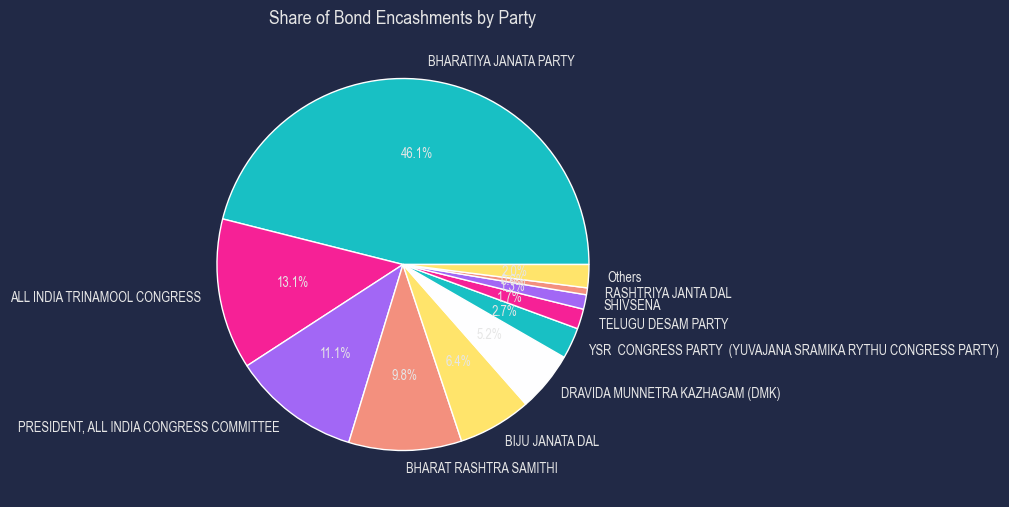

In [674]:
# plot_donut_chart(party_buyers_agg["Party"], color_map=Inferno256[len(party_buyers_agg["Party"].unique())])
first_ten = parties_agg.head(10)
others_aggregated = pd.DataFrame({
    'Party': ['Others'],
    'Denominations': [parties_agg.iloc[10:]['Denominations'].sum()]
})
plot_parties_agg = pd.concat([first_ten, others_aggregated]).reset_index(drop=True)

plt.figure(figsize=(6,8))
plt.rcParams["font.size"] = 10
plt.rcParams["font.stretch"] = "condensed"
plt.pie(plot_parties_agg['Denominations'], labels=plot_parties_agg['Party'], autopct='%1.1f%%', startangle=0)
plt.title('Share of Bond Encashments by Party', fontsize=14)
plt.show()

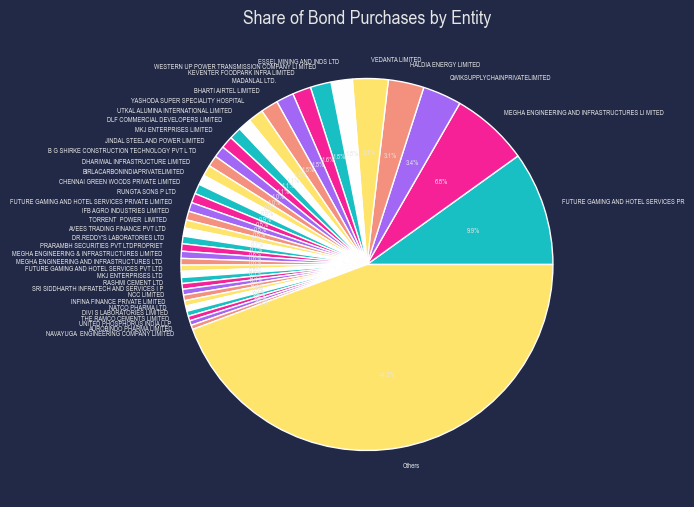

In [673]:
first_ten = buyers_agg.head(40)
others_aggregated = pd.DataFrame({
    'Buyer': ['Others'],
    'Denominations': [buyers_agg.iloc[40:]['Denominations'].sum()]
})
plot_buyers_agg = pd.concat([first_ten, others_aggregated]).reset_index(drop=True)

plt.figure(figsize=(6,8))
plt.rcParams["font.size"] = 5
plt.rcParams["font.stretch"] = "condensed"
plt.pie(plot_buyers_agg['Denominations'], labels=plot_buyers_agg['Buyer'], autopct='%1.1f%%')
plt.title('Share of Bond Purchases by Entity', fontsize=14)
plt.show()

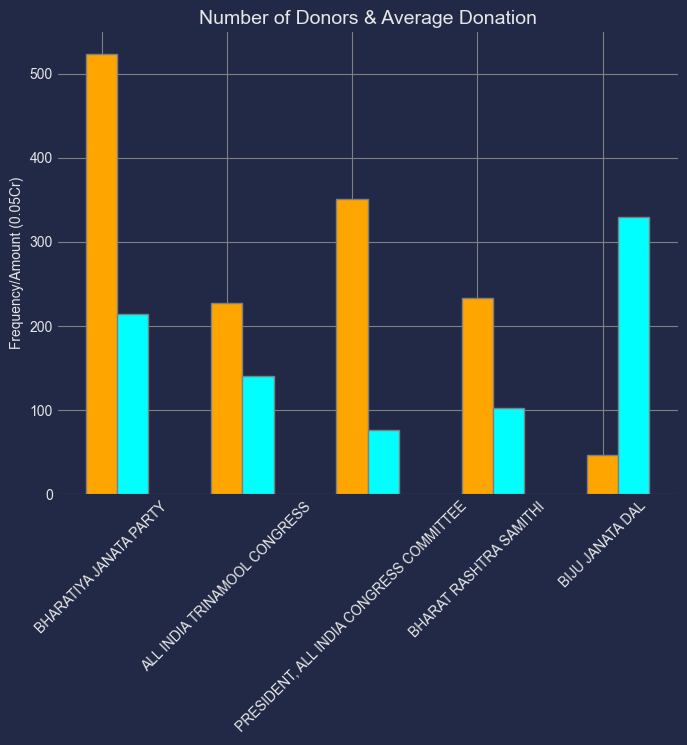

In [677]:
barWidth = 0.25
r1 = np.arange(len(parties_agg.iloc[:5]['Party']))
r2 = [x + barWidth for x in r1]

plt.rcParams["font.size"] = 10
plt.rcParams["font.stretch"] = "semi-condensed"
plt.rcParams['grid.color'] = 'grey'

plt.figure(figsize=(8,6))
plt.bar(r1, parties_agg.iloc[:5]['Buyer Count'], color="orange", width=barWidth, edgecolor='grey', label='Number of Donors')
plt.bar(r2, parties_agg.iloc[:5]['Buyer Average'].apply(lambda x: x*20), color="cyan", width=barWidth, edgecolor='grey', label='Average Donation')

plt.xticks(r1, parties_agg.iloc[:5]["Party"], rotation=45)
plt.ylabel('Frequency/Amount (0.05Cr)')
plt.title('Number of Donors & Average Donation', fontsize=14)
plt.show()

In [661]:
transactions2 = transactions
transactions2["Date_Purchase"] = transactions2["Date_Purchase"].apply(lambda x: pd.to_datetime(x).strftime('%Y/%m'))
plot_data = transactions2.groupby("Date_Purchase").sum().reset_index()
dates = pd.DataFrame({"Date_Purchase": pd.date_range(plot_data.iloc[0, 0], plot_data.iloc[-1, 0], freq='m').to_series().apply(lambda x: x.strftime('%Y/%m'))})
plot_data = pd.merge(dates, plot_data, on='Date_Purchase', how='outer').fillna(0)
plot_data["movavg"] = plot_data["Denominations"].rolling(6).sum()
plot_data

,Date_Purchase,Denominations,movavg
0,2019/04,665.3101,NaN
1,2019/05,819.2575,NaN
2,2019/06,0.0000,NaN
3,2019/07,45.3800,NaN
4,2019/08,0.0000,NaN
5,2019/09,0.0000,1529.9476
6,2019/10,231.9300,1096.5675
7,2019/11,0.0000,277.3100
8,2019/12,0.0000,277.3100
9,2020/01,81.6700,313.6000


In [662]:
bjp_plot_data = transactions2[transactions2["Party"] == "BHARATIYA JANATA PARTY"].groupby("Date_Purchase").sum().reset_index()
bjp_plot_data = pd.merge(dates, bjp_plot_data, on='Date_Purchase', how='outer').fillna(0)
bjp_plot_data["movavg"] = bjp_plot_data["Denominations"].rolling(6).sum()
inc_plot_data = transactions2[transactions2["Party"] == "PRESIDENT, ALL INDIA CONGRESS COMMITTEE"].groupby("Date_Purchase").sum().reset_index()
inc_plot_data = pd.merge(dates, inc_plot_data, on='Date_Purchase', how='outer').fillna(0)
inc_plot_data["movavg"] = inc_plot_data["Denominations"].rolling(6).sum()

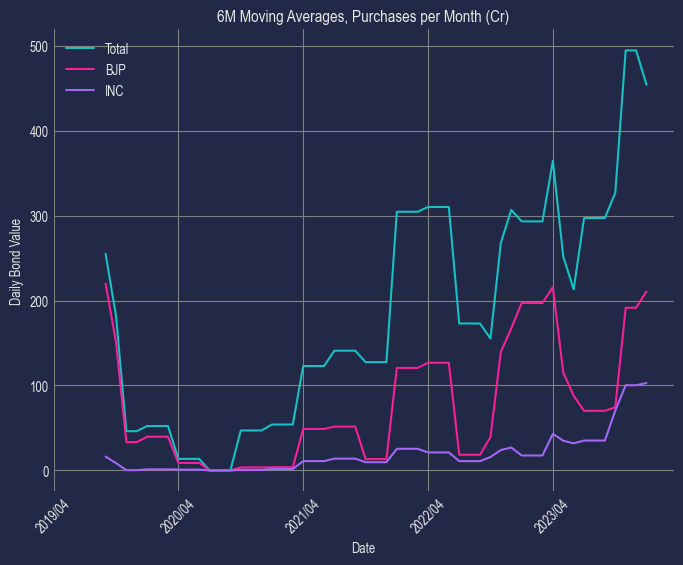

In [676]:
plt.figure(figsize=(8,6))
plt.plot(plot_data["Date_Purchase"], plot_data["movavg"]/6)
plt.plot(bjp_plot_data["Date_Purchase"], bjp_plot_data["movavg"]/6)
plt.plot(inc_plot_data["Date_Purchase"], inc_plot_data["movavg"]/6)

# plt.axvline(x=10, linestyle='--', linewidth=0.5)

plt.xticks(plot_data['Date_Purchase'][::12], plot_data['Date_Purchase'][::12], rotation=45)
plt.xlabel('Date')
plt.ylabel('Daily Bond Value')
plt.title('6M Moving Averages, Purchases per Month (Cr)', fontsize=12)
plt.legend(["Total", "BJP", "INC"], loc="upper left")
plt.show()

In [664]:
top_buyers = party_buyers_agg.groupby('Buyer')['Denominations'].sum().nlargest(20)
# top_parties = party_buyers_agg.groupby('Party')['Denominations'].sum().nlargest(20)
top_transactions = party_buyers_agg[party_buyers_agg['Buyer'].isin(top_buyers.index)]
# top_buyers = top_transactions.groupby('Buyer')['Denominations'].sum()
top_parties = top_transactions.groupby('Party')['Denominations'].sum()

In [665]:
level1 = sorted([(key, value) for key, value in top_buyers.items()], key=lambda x: x[1], reverse=True)
level2 = sorted([(key, value) for key, value in top_parties.items()], key=lambda x: x[1], reverse=True)
flows = list(top_transactions.apply(lambda row: (row["Buyer"], row["Party"], row["Denominations"]), axis=1))

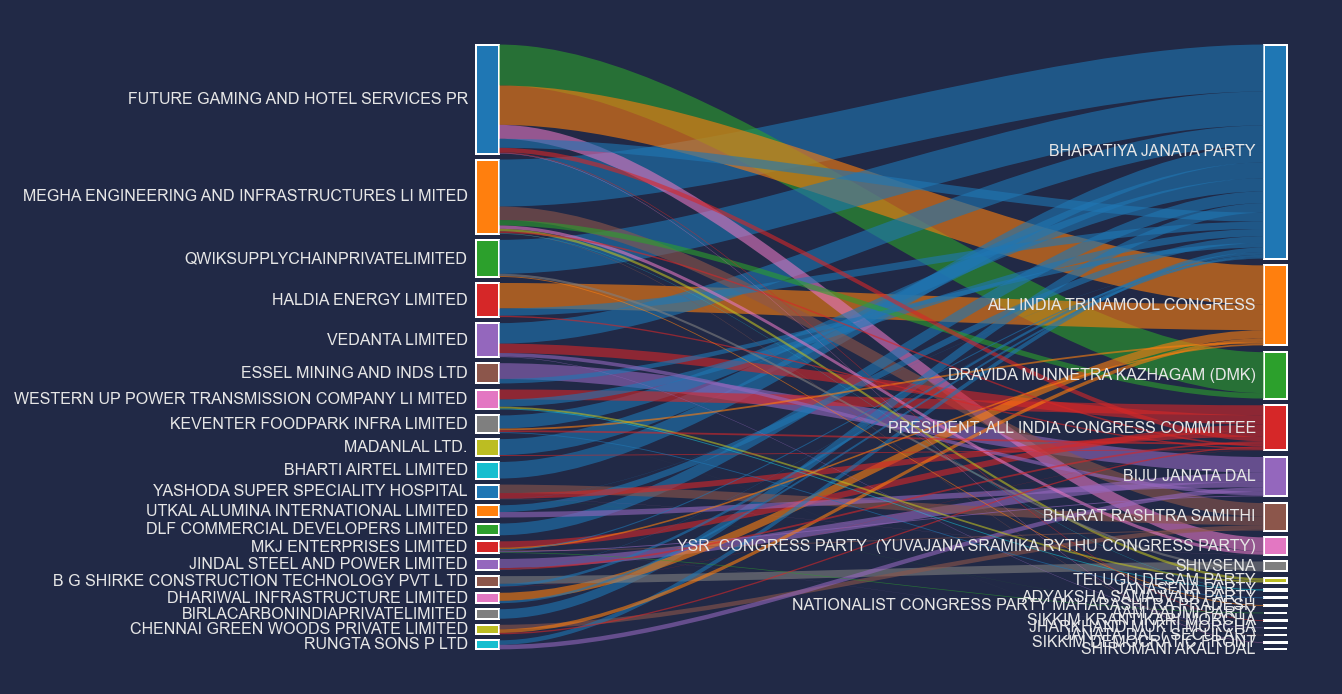

In [666]:
plt.figure(figsize=(8, 6), dpi=144)
s = Sankey(flows=flows, nodes=[level1, level2], node_opts=dict(label_pos="left", label_opts={"fontsize": 8}, label_format='{label}'))
s.draw()